# Computational Drug Discovery

## Importing Libraries

In [190]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

## Fetch and upload bioactivity data for Human Acetylcholinesterase

In [2]:
url = 'https://raw.githubusercontent.com/dataprofessor/data/master/acetylcholinesterase_01_bioactivity_data_raw.csv'

In [3]:
response = requests.get(url)

In [4]:
with open('acetylcholinesterase_01_bioactivity_data_raw.csv', 'wb') as f:
    f.write(response.content)

In [5]:
df = pd.read_csv('acetylcholinesterase_01_bioactivity_data_raw.csv')

In [6]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,NaN,18798886,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.81
7022,NaN,18798887,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.46
7023,NaN,18798888,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.78
7024,NaN,18798889,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.45


## Data Preparation

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7026 entries, 0 to 7025
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           1245 non-null   object 
 1   activity_id                7026 non-null   int64  
 2   activity_properties        7026 non-null   object 
 3   assay_chembl_id            7026 non-null   object 
 4   assay_description          7026 non-null   object 
 5   assay_type                 7026 non-null   object 
 6   bao_endpoint               7026 non-null   object 
 7   bao_format                 7026 non-null   object 
 8   bao_label                  7026 non-null   object 
 9   canonical_smiles           6991 non-null   object 
 10  data_validity_comment      529 non-null    object 
 11  data_validity_description  529 non-null    object 
 12  document_chembl_id         7026 non-null   object 
 13  document_journal           6092 non-null   objec

### Drop Missing Values

In [8]:
df2 = df[(df.standard_value.notna()) & df.canonical_smiles.notna()]

In [9]:
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,NaN,18798886,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.81
7022,NaN,18798887,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.46
7023,NaN,18798888,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.78
7024,NaN,18798889,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.45


### Drop Duplicates

In [10]:
sum(df2.duplicated(['canonical_smiles']))

1140

In [11]:
df_nr = df2.drop_duplicates(['canonical_smiles'])

In [12]:
sum(df_nr.duplicated(['canonical_smiles']))

0

In [13]:
df_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,NaN,18798884,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.44
7020,NaN,18798885,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.54
7021,NaN,18798886,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.81
7022,NaN,18798887,[],CHEMBL4274263,Inhibition of human erythrocyte AChE using ace...,B,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.46


In [14]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df_nr[selection]

In [15]:
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0
...,...,...,...
7019,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0
7020,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0
7021,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0
7022,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0


In [18]:
df3.to_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv', index = False)

### Labeling Compounds

In [19]:
df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [20]:
bioactivity_class = []
for i in df3['standard_value']:
    if i >= 10000:
        bioactivity_class.append('inactive')
    elif i <= 1000:
        bioactivity_class.append('active')
    else:
        bioactivity_class.append('intermediate')

In [22]:
df['bioactivity_class'] = bioactivity_class

In [23]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


In [25]:
df.to_csv('acetylcholinesterase_03_bioactivity_data_curated.csv', index = False)

### Cleaning canonical_smiles

In [26]:
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')

In [27]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


In [28]:
smiles = []
for i in df3['canonical_smiles']:
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)

In [29]:
df['canonical_smiles'] = smiles

In [32]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


### Calculate Lipinski descriptors

In [33]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


In [34]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [35]:
df_lipinski = lipinski(df.canonical_smiles)

In [36]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
4690,511.150,7.07230,2.0,3.0
4691,511.150,7.07230,2.0,3.0
4692,555.601,7.18140,2.0,3.0
4693,521.702,6.32710,2.0,5.0


In [37]:
df_combined = pd.concat([df, df_lipinski], axis = 1)

In [38]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate,511.150,7.07230,2.0,3.0
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate,511.150,7.07230,2.0,3.0
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate,555.601,7.18140,2.0,3.0
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate,521.702,6.32710,2.0,5.0


### Converting IC50 to pIC50

- `pIC50 = -log10(IC50)`
- IC50 is not uniformly distributed.

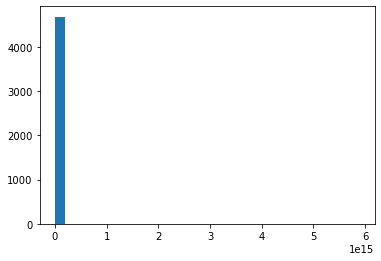

In [39]:
plt.hist(df_combined['standard_value'], bins = 30);

In [40]:
df_combined['standard_value'].describe()

count    4.695000e+03
mean     3.210931e+12
std      1.189580e+14
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

- We need to cap the values of `standard_value` column at 100000000.

In [41]:
def norm_value(input_df):
    norm = []
    for i in input_df['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
    input_df['standard_value_norm'] = norm
    x = input_df.drop('standard_value', axis = 1)
    return x

In [42]:
df_norm = norm_value(df_combined)

In [43]:
df_norm['standard_value_norm'].describe()

count    4.695000e+03
mean     3.276494e+05
std      4.718369e+06
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [44]:
def pIC50(input_df):
    pIC50 = []
    for i in input_df['standard_value_norm']:
        molar = i * (10**-9) #converts nM to M
        pIC50.append(-np.log10(molar))
    input_df['pIC50'] = pIC50
    x = input_df.drop('standard_value_norm', axis = 1)
    return x

In [45]:
df_final = pIC50(df_norm)

In [46]:
df_final['pIC50'].describe()

count    4695.000000
mean        5.820864
std         1.552813
min         1.000000
25%         4.756219
50%         5.648590
75%         6.903090
max        11.221849
Name: pIC50, dtype: float64

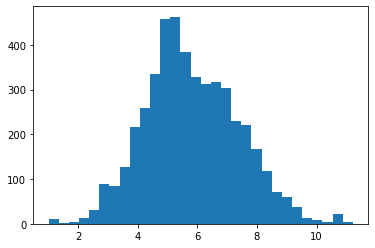

In [47]:
plt.hist(df_final['pIC50'], bins = 30);

In [48]:
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv', index = False)

- Now the pIC50 values are more uniformly distributed.

### Remove the "intermediate" Bioactivity Class

In [49]:
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']

In [50]:
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4675,CHEMBL4284261,CCN(C)Cc1cc(N)ccc1O,inactive,180.251,1.4261,2.0,3.0,3.015428
4676,CHEMBL4276921,CN(C)Cc1cc(N)ccc1O,inactive,166.224,1.0360,2.0,3.0,2.813467
4677,CHEMBL4292574,CNCc1cc(N)ccc1O,inactive,152.197,0.6938,3.0,3.0,3.476904
4685,CHEMBL4292766,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3F)CC2...,active,494.695,6.5580,2.0,3.0,6.124939


In [51]:
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv', index = False)

## Exploratory Data Analysis (Chemical Space Analysis)

### Frequency Plot of the Two Bioactivity Classes

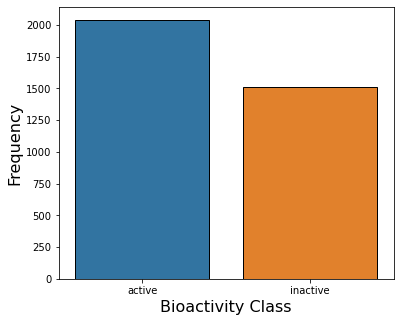

In [52]:
plt.figure(figsize = (6,5))
sb.countplot(data = df_2class, x = 'bioactivity_class', edgecolor = 'black')
plt.xlabel('Bioactivity Class', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16);

### Scatter Plot of MW vs LogP

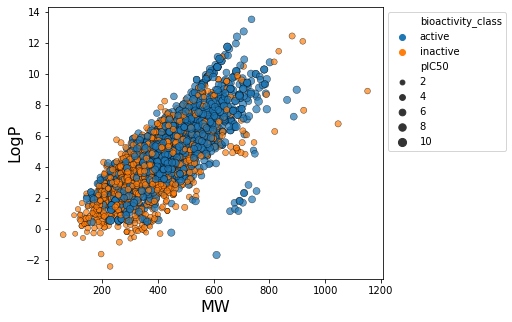

In [53]:
plt.figure(figsize = (6,5))
sb.scatterplot(data = df_2class, x = 'MW', y = 'LogP', hue = 'bioactivity_class', size = 'pIC50',
               edgecolor = 'black', alpha = 0.7)
plt.legend(bbox_to_anchor = (1,1),loc = 2)
plt.xlabel('MW', fontsize = 16)
plt.ylabel('LogP', fontsize = 16);

In [54]:
def mannwhitney(descriptor, verbose=False):
    '''
        This function determines whether the difference
        between the active and the inactive molecules is
        statistically significant with respect to each of
        the Lipinski's descriptors
    '''
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    # seed the random number generator
    seed(1)

    # actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]

    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                              'Statistics':stat,
                              'p':p,
                              'alpha':alpha,
                              'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

### Box Plots

#### pIC50

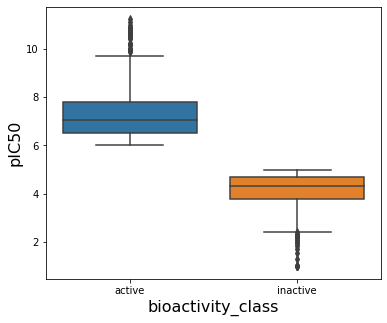

In [55]:
plt.figure(figsize = (6,5))
sb.boxplot(data = df_2class, x = 'bioactivity_class', y = 'pIC50')
plt.xlabel('bioactivity_class', fontsize = 16)
plt.ylabel('pIC50', fontsize = 16);

- Molecules with pIC50 values of 6 or more will be active, while those with pIC50 values of less than 6 will be inactive.
- The distribution of the inactive compounds is wider than that of the active molecules.

In [56]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3078890.0,0.0,0.05,Different distribution (reject H0)


#### MW

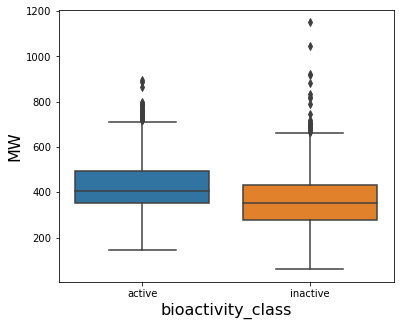

In [57]:
plt.figure(figsize = (6,5))
sb.boxplot(data = df_2class, x = 'bioactivity_class', y = 'MW')
plt.xlabel('bioactivity_class', fontsize = 16)
plt.ylabel('MW', fontsize = 16);

In [58]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2020111.0,4.144511e-57,0.05,Different distribution (reject H0)


#### LogP

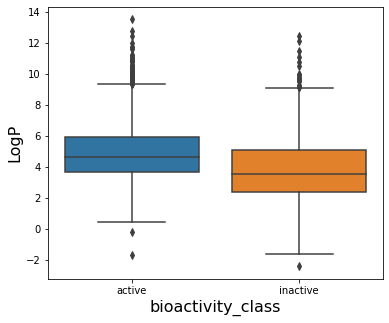

In [59]:
plt.figure(figsize = (6,5))
sb.boxplot(data = df_2class, x = 'bioactivity_class', y = 'LogP')
plt.xlabel('bioactivity_class', fontsize = 16)
plt.ylabel('LogP', fontsize = 16);

In [60]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2036990.0,4.637335e-61,0.05,Different distribution (reject H0)


#### NumHDonors

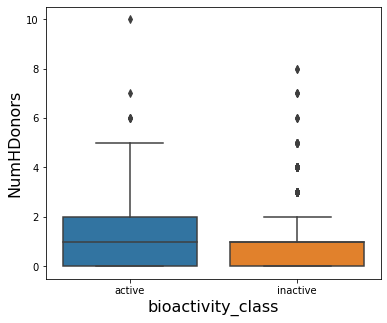

In [61]:
plt.figure(figsize = (6,5))
sb.boxplot(data = df_2class, x = 'bioactivity_class', y = 'NumHDonors')
plt.xlabel('bioactivity_class', fontsize = 16)
plt.ylabel('NumHDonors', fontsize = 16);

In [62]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1717884.5,5.040191e-10,0.05,Different distribution (reject H0)


#### NumHAcceptors

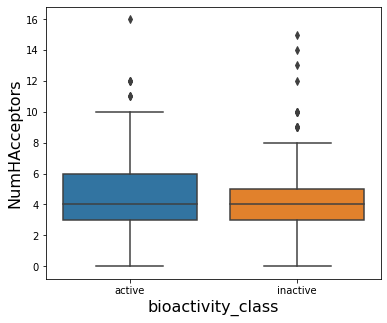

In [63]:
plt.figure(figsize = (6,5))
sb.boxplot(data = df_2class, x = 'bioactivity_class', y = 'NumHAcceptors')
plt.xlabel('bioactivity_class', fontsize = 16)
plt.ylabel('NumHAcceptors', fontsize = 16);

In [64]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1671317.5,0.000009,0.05,Different distribution (reject H0)


#### Analysis Interpretation

##### pIC50 values
Active and inactive molecules showed statistically significant difference with respect to the pIC50, which is to be expected since molecules with IC50 <= 1000 nM (pIC50 <= 6) are active, while molecules iwth IC50 > 10000 (pIC50 < 5) are inactive.

##### Lipinski's descriptors
All of the 4 Lipinski's descriptors exhibited statistically significant difference between the active and the inactive molecules.

In [65]:
df_2class.to_csv('acetylcholinesterase_03_bioactivity_data_2class_pIC50.csv', index = False)

## Download PaDEL-Descriptor

- Used to calculate molecular descriptors and pubchem fingerprints.
- Pubchem fingerprints describe the local features (the unique building blocks) of the molecule.
- The connectivity of the building blocks are giving rise to the unque structure of the molecule and also the unique molecular properties.

In [84]:
padel_zip_url = 'https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip'
padel_sh_url = 'https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh'

In [85]:
padel_zip_resp = requests.get(padel_zip_url)

In [86]:
padel_sh_resp = requests.get(padel_sh_url)

In [87]:
with open('padel.zip', 'wb') as f:
    f.write(padel_zip_resp.content)

In [88]:
with zipfile.ZipFile('padel.zip', 'r') as f:
    f.extractall('padel_files')

In [89]:
with open('padel.sh', 'wb') as f:
    f.write(padel_sh_resp.content)

In [66]:
df_3class = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

In [67]:
df_3class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,5.612610
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,5.595166
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,5.419075
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,5.460924


In [68]:
selection = ['canonical_smiles', 'molecule_chembl_id']

In [69]:
df_3class_selection = df_3class[selection]

In [70]:
df_3class_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [104]:
descriptors_url = 'https://raw.githubusercontent.com/dataprofessor/data/master/descriptors_output.csv'

In [105]:
descriptors_resp = requests.get(descriptors_url)

In [108]:
with open('descriptors_output.csv', 'wb') as f:
    f.write(descriptors_resp.content)

### Preparing the X and Y Data Matrices

#### X Matrix

In [109]:
df_3class_X = pd.read_csv('descriptors_output.csv')

In [111]:
df_3class_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4691,CHEMBL4282558,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4692,CHEMBL4281727,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4693,CHEMBL4292349,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
df_3class_X.drop('Name', axis = 1, inplace = True)

In [113]:
df_3class_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4691,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4692,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4693,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Y Matrix

In [115]:
df_3class_Y = df_3class['pIC50']
df_3class_Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
4690    5.612610
4691    5.595166
4692    5.419075
4693    5.460924
4694    5.555955
Name: pIC50, Length: 4695, dtype: float64

#### Combine X and Y matrices

In [117]:
dataset_3class = pd.concat([df_3class_X, df_3class_Y], axis = 1)

In [118]:
dataset_3class

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.612610
4691,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.595166
4692,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.419075
4693,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.460924


In [119]:
dataset_3class.to_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index = False)

## Model Building

In [121]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Columns: 882 entries, PubchemFP0 to pIC50
dtypes: float64(1), int64(881)
memory usage: 31.6 MB


- The dataset contains 881 input features and 1 output label.

### Separating the Input Features and the Output Labels

#### Input Features (X)

In [125]:
X = df.drop('pIC50', axis =1)

In [127]:
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4691,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4692,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4693,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Output Labels

In [128]:
y = df['pIC50']

In [129]:
X.shape

(4695, 881)

In [130]:
y.shape

(4695,)

### Remove Low-Variance Features

In [136]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))

In [133]:
t = selection.fit_transform(X)

In [137]:
X = selection.fit_transform(X)

In [138]:
X.shape

(4695, 137)

### Create a Test Set

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [142]:
X_train.shape, y_train.shape

((3756, 137), (3756,))

In [143]:
X_test.shape, y_test.shape

((939, 137), (939,))

### Build a Regression Model

In [144]:
np.random.seed(100)
forest_reg = RandomForestRegressor(n_estimators = 100)

In [145]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [146]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [148]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring = 'r2')

In [149]:
display_scores(forest_scores)

Scores: [0.50771956 0.52479007 0.52893357 0.49005266 0.53172357]
Mean: 0.5166438856836975
Standard deviation: 0.015694142813017266


In [150]:
X_train.shape

(3756, 137)

In [154]:
param_grid = [
    {'n_estimators':[50,70,100], 'max_features':[60,80,100,120]},
    {'bootstrap':[False], 'n_estimators':[70,100], 'max_features':[80,100,120]}
]

grid_search = GridSearchCV(estimator = forest_reg, param_grid = param_grid, cv = 5, scoring = 'r2',
                           return_train_score = True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [60, 80, 100, 120],
                          'n_estimators': [50, 70, 100]},
                         {'bootstrap': [False], 'max_features': [80, 100, 120],
                          'n_estimators': [70, 100]}],
             return_train_score=True, scoring='r2')

In [155]:
cvres = grid_search.cv_results_

In [157]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.5181971859608944 {'max_features': 60, 'n_estimators': 50}
0.514949928640798 {'max_features': 60, 'n_estimators': 70}
0.5195175982045901 {'max_features': 60, 'n_estimators': 100}
0.5126749201234796 {'max_features': 80, 'n_estimators': 50}
0.5157736589973559 {'max_features': 80, 'n_estimators': 70}
0.5186834088790586 {'max_features': 80, 'n_estimators': 100}
0.5179597825115515 {'max_features': 100, 'n_estimators': 50}
0.5156832656085171 {'max_features': 100, 'n_estimators': 70}
0.5176989855668112 {'max_features': 100, 'n_estimators': 100}
0.5177267109416555 {'max_features': 120, 'n_estimators': 50}
0.5130164487608498 {'max_features': 120, 'n_estimators': 70}
0.5174215781221783 {'max_features': 120, 'n_estimators': 100}
0.4658956267353108 {'bootstrap': False, 'max_features': 80, 'n_estimators': 70}
0.46893550946912993 {'bootstrap': False, 'max_features': 80, 'n_estimators': 100}
0.4554172699957027 {'bootstrap': False, 'max_features': 100, 'n_estimators': 70}
0.4533518041990952 {'bootstr

In [162]:
model = grid_search.best_estimator_

In [163]:
model_scores = cross_val_score(model, X_train, y_train, scoring = 'r2')

In [164]:
display_scores(model_scores)

Scores: [0.50884302 0.52442513 0.52724841 0.4900436  0.53471815]
Mean: 0.5170556641462613
Standard deviation: 0.01592019721254284


### Testing on the Test Set

In [169]:
y_pred = model.predict(X_test)

In [170]:
r2 = r2_score(y_test, y_pred)

In [171]:
r2

0.5211695107092156

In [172]:
model.score(X_test, y_test)

0.5211695107092156

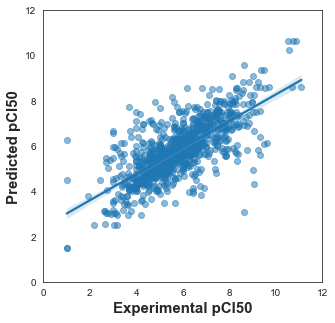

In [183]:
plt.figure(figsize = (5,5))
sb.set_style('white')
sb.regplot(x = y_test, y = y_pred, scatter_kws = {'alpha':0.5})
plt.xlim(0,12)
plt.ylim(0,12)
plt.xlabel('Experimental pCI50', fontsize = 15, fontweight = 'bold')
plt.ylabel('Predicted pCI50', fontsize = 15, fontweight = 'bold');